In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
from tqdm import tqdm  # progress bar
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

def compute_nmi_r2(umap_df, mask, N_class):
    temp_emb = umap_df.loc[mask, ["umap1", "umap2"]]
    labels_true = np.array(umap_df.loc[mask, "angle"] * (N_class-1)).astype(int)
    # --- KMeans for NMI ---
    kmeans = KMeans(n_clusters=N_class, random_state=0)
    labels_pred = kmeans.fit_predict(temp_emb)
    nmi_score = normalized_mutual_info_score(labels_true, labels_pred)
    # --- Linear Regression for R² ---
    model_LR = LinearRegression()
    model_LR.fit(temp_emb, labels_true)
    labels_pred_LR = model_LR.predict(temp_emb)
    r2_LR = np.round(r2_score(labels_true, labels_pred_LR), 2)
    return nmi_score, r2_LR

import warnings
warnings.filterwarnings("ignore", message=".*force_all_finite.*")
warnings.filterwarnings("ignore", message=".*n_jobs value 1 overridden to 1.*")
warnings.filterwarnings("ignore", message=".*Graph is not full*")

N_arch = 10

n_neighbors = 200
min_dist = 1
state_id = 0

X_raw_all = [f"./emb/sm_spectral_IHC3000_A{i:02d}_all_emb_penultimate_512.npy" for i in range(1, 11)]
azim_labels_all = [f"./emb/sm_spectral_IHC3000_A{i:02d}_all_azimuth.npy" for i in range(1, 11)]
elev_labels_all = [f"./emb/sm_spectral_IHC3000_A{i:02d}_all_elevation.npy" for i in range(1, 11)]
smoothed_labels_all = [f"./emb/sm_spectral_IHC3000_A{i:02d}_all_smoothed.npy" for i in range(1, 11)]

mean_dist_all = []
for m in tqdm(range(N_arch)):

    X_raw = np.load(X_raw_all[m]) ## (2340, 512)
    azim_labels = np.squeeze(np.load(azim_labels_all[m])) ## (2340,)
    azim_labels = ((azim_labels + 180) % 360) - 180   ## [-180,    0] degress
    elev_labels = np.squeeze(np.load(elev_labels_all[m])) ## [ 0, 10, 20, 30, 40, 50, 60]
    smoothed_labels = np.squeeze(np.load(smoothed_labels_all[m])) ## [  1,   2,   4,   8,  16,  32,  64, 128, 256]
    
    mask = np.isin(azim_labels, [0]) # choose either 0deg=front or 180deg=back
    indices = np.where(mask)[0]
    
    X = X_raw[indices]
    c = elev_labels[indices] # without considering elevation
    c = (c - c.min()) / (c.max() - c.min()) 
    # print('number of total stimuli='+str(len(c)))
    N_class = len(np.unique(c))
    
    umap_model = umap.UMAP(n_neighbors = n_neighbors, min_dist=min_dist, 
                           n_components=2, random_state=state_id) 
    umap_results = umap_model.fit_transform(X) ## (262200, 2)
    
    warnings.filterwarnings("ignore", message=".*get_cmap*")
    umap_df = pd.DataFrame({
        "umap1": umap_results[:, 0],
        "umap2": umap_results[:, 1],
        "angle": c,
        "smoothed": smoothed_labels[indices],
        "elevation": elev_labels[indices],
    })
    
    fig, ax = plt.subplots(figsize=(6, 6))
    
    cmap = plt.cm.get_cmap('jet')
    colors = cmap(umap_df["angle"].values)
    
    marker_size = 50
    N_smooth = len(np.unique(smoothed_labels))
    for s in range(N_smooth):
        s_val = np.unique(smoothed_labels)[s]
        mask_r = (umap_df["smoothed"] == s_val)
        nmi, r2 = compute_nmi_r2(umap_df, mask_r, N_class)
        # print('smoothed='+str(s_val)+' nmi='+str(round(nmi,2))+' r2='+str(round(r2,2)))
    
    mask_r = (umap_df["smoothed"] ==256)
    nmi, r2 = compute_nmi_r2(umap_df, mask_r, N_class)
    label_text = f"sm 256 {nmi:.2f} {r2:.2f}"
    ax.scatter(
        umap_df.loc[mask_r, "umap1"],
        umap_df.loc[mask_r, "umap2"],
        s=marker_size*1,
        facecolors='white',
        edgecolors=colors[mask_r],
        alpha=0.9,
        linewidths=1,
        marker='o',
        label=label_text,
    )
    
    mask_r = (umap_df["smoothed"] == 64)
    nmi, r2 = compute_nmi_r2(umap_df, mask_r, N_class)
    label_text = f"sm 64 {nmi:.2f} {r2:.2f}"
    ax.scatter(
        umap_df.loc[mask_r, "umap1"],
        umap_df.loc[mask_r, "umap2"],
        s=marker_size*1,
        facecolors='silver',
        edgecolors=colors[mask_r],
        alpha=0.9,
        linewidths=1,
        marker='s',
        label=label_text,
    )
    
    mask_r = (umap_df["smoothed"] == 16)
    nmi, r2 = compute_nmi_r2(umap_df, mask_r, N_class)
    label_text = f"sm 16 {nmi:.2f} {r2:.2f}"
    ax.scatter(
        umap_df.loc[mask_r, "umap1"],
        umap_df.loc[mask_r, "umap2"],
        s=marker_size*1,
        facecolors='gray',
        edgecolors=colors[mask_r],
        alpha=0.9,
        linewidths=1,
        marker='d',
        label=label_text,
    )
    
    mask_r = (umap_df["smoothed"] == 1)
    nmi, r2 = compute_nmi_r2(umap_df, mask_r, N_class)
    label_text = f"sm 1 {nmi:.2f} {r2:.2f}"
    ax.scatter(
        umap_df.loc[mask_r, "umap1"],
        umap_df.loc[mask_r, "umap2"],
        s=marker_size*1,
        facecolors='black',
        edgecolors=colors[mask_r],
        alpha=0.9,
        linewidths=1,
        marker='p',
        label=label_text,
    )
    
    norm = plt.Normalize(0, 1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    ax.set_aspect("equal", "box")
    ax.legend(markerscale=1, frameon=False)
    plt.tight_layout()
    plt.savefig(f"IHC3000_A{m+1:02d}"+'_n_neighbors'+str(n_neighbors)+'_min_dist'+str(min_dist)+'_emb.pdf', 
                dpi=300, bbox_inches='tight')
    plt.close()
    
    # ---------- 1. prepare unique smooth factors and elevations ----------
    # smooth_vals = np.unique(umap_df["smoothed"].values)      # e.g. [  1, 2, 4, ..., 256]
    smooth_vals = np.sort(np.unique(umap_df["smoothed"].values))
    elev_vals   = np.unique(umap_df["elevation"].values)     # e.g. [0, 10, ..., 60]
    
    n_smooth = len(smooth_vals)
    n_elev   = len(elev_vals)
    
    # distance[smooth_idx, elev_idx]
    dist_array = np.full((n_smooth, n_elev), np.nan)
    
    ref_smooth = 256  # minimal smoothing, used as reference
    
    # ---------- 2. pre-compute reference centroids for smoothed = 256 ----------
    ref_centers = {}  # elevation -> 2D centroid
    
    for j, elev in enumerate(elev_vals):
        mask_ref = (umap_df["smoothed"] == ref_smooth) & (umap_df["elevation"] == elev)
        pts_ref = umap_df.loc[mask_ref, ["umap1", "umap2"]].values
        if len(pts_ref) == 0:
            continue
        ref_centers[elev] = pts_ref.mean(axis=0)
    
    # ---------- 3. distances for every (smooth, elevation) ----------
    for i, s_val in enumerate(smooth_vals):
        for j, elev in enumerate(elev_vals):
            # skip if we have no reference centroid for this elevation
            if elev not in ref_centers:
                continue
            mask_s = (umap_df["smoothed"] == s_val) & (umap_df["elevation"] == elev)
            pts_s = umap_df.loc[mask_s, ["umap1", "umap2"]].values
            if len(pts_s) == 0:
                continue
            center_s = pts_s.mean(axis=0)
            center_ref = ref_centers[elev]
            # Euclidean distance between centroids
            dist_array[i, j] = np.linalg.norm(center_s - center_ref)
    
    # print("distance array shape:", dist_array.shape)  # (n_smooth, n_elev)
    
    # ---------- 4. compute mean and SEM across elevations ----------
    mean_dist = np.nanmean(dist_array, axis=1)
    mean_dist_all.append(mean_dist)
    sem_dist = np.zeros_like(mean_dist)
    for i in range(n_smooth):
        row = dist_array[i, :]
        valid = np.isfinite(row)
        n_valid = valid.sum()
        if n_valid > 1:
            sem_dist[i] = np.nanstd(row[valid], ddof=1) / np.sqrt(n_valid)
        else:
            sem_dist[i] = 0.0
    
    # ---------- 5. plot: dots for each elevation, mean ± SEM ----------
    fig, ax = plt.subplots(figsize=(7, 5))
    cmap = plt.cm.get_cmap('jet', len(elev_vals))
    # individual elevations as dots
    for j, elev in enumerate(elev_vals):
        ax.scatter(
            smooth_vals,
            dist_array[:, j],
            s=40,
            color=cmap(j),
            alpha=0.8,
            # label=f"elev {int(elev)}°" if j == 0 else None,  # label only once to avoid clutter
            label=f"elev {int(elev)}°"
        )
    
    ### mean ± SEM (line with error bars)
    ax.errorbar(
        smooth_vals,
        mean_dist,
        yerr=sem_dist,
        fmt="-o",
        linewidth=2,
        color='black',
        capsize=0,
        markersize=2,
        label="mean ± SEM",
    )
    
    ax.set_xscale("log", base=2)  # optional; remove if you want linear x-axis
    ax.set_xticks(smooth_vals)
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())  # show tick labels as 1,2,4,...
    ax.set_xlabel("Number of cosines")
    ax.invert_xaxis()
    ax.set_ylabel("Distance to smoothed = 256 (centroid distance)")
    ax.set_title("Distance vs. Number of cosines (relative to 256)")
    # ax.grid(True, alpha=0.3)
    ax.legend(frameon=False)
    
    plt.tight_layout()
    plt.savefig(f"IHC3000_A{m+1:02d}"+'_n_neighbors'+str(n_neighbors)+'_min_dist'+str(min_dist)+'_quantify.pdf', 
                dpi=300, bbox_inches='tight')
    plt.close()

100%|███████████████████████████████████████████| 10/10 [00:48<00:00,  4.84s/it]


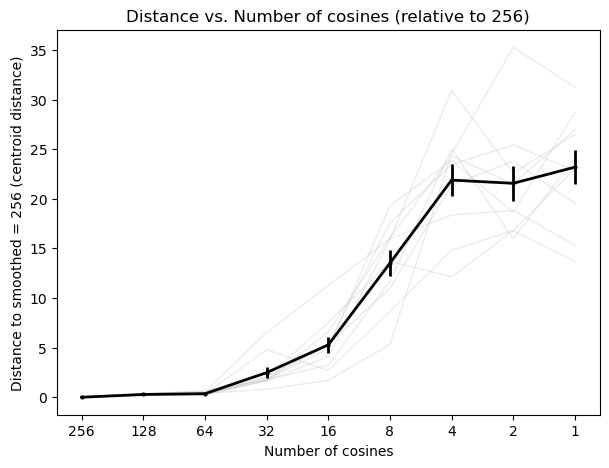

In [2]:
arch_mean=np.nanmean(mean_dist_all, axis=0)
arch_std=np.std(mean_dist_all, axis=0)
arch_sem=arch_std/np.sqrt(N_arch)
fig, ax = plt.subplots(figsize=(7, 5))
for i in range(N_arch):
    ax.plot(
        smooth_vals,
        mean_dist_all[i],
        marker="o",
        linewidth=1,
        markersize=0,
        alpha=0.3,
        color="silver",    # orange
    )
ax.errorbar(
        smooth_vals,
        arch_mean,
        yerr=arch_sem,
        fmt="-o",
        linewidth=2,
        color='black',
        capsize=0,
        markersize=2,
        label="mean ± SEM",
    )
ax.set_xscale("log", base=2)  # optional; remove if you want linear x-axis
ax.set_xticks(smooth_vals)
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())  # show tick labels as 1,2,4,...
ax.set_xlabel("Number of cosines")
ax.invert_xaxis()
ax.set_ylabel("Distance to smoothed = 256 (centroid distance)")
ax.set_title("Distance vs. Number of cosines (relative to 256)")
plt.savefig(f"IHC3000_Arch_All"+'_n_neighbors'+str(n_neighbors)+'_min_dist'+str(min_dist)+'.pdf', 
                dpi=300, bbox_inches='tight')
# ax.legend(frameon=False)